# Import the Libraries

In [165]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import exposure
from skimage import feature

from pandas import read_excel

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score


## HOG Feature Extraction

In [166]:
from IPython.display import clear_output

def get_feature_vector(image_directory, grid_q= 4, orientation= 8, edge= False):
    img= cv2.imread(image_directory, cv2.IMREAD_GRAYSCALE)
    if edge== True:
        img= cv2.Canny(img, 100, 200)

    hog_features = hog(img, orientations= orientation, pixels_per_cell= (int(img.shape[0]/grid_q), int(img.shape[1]/grid_q)),
                    cells_per_block=(1, 1), feature_vector= True)

    return hog_features


feature_matrix= []
for i in range(1, 1300):
    img_dir= "./pictures2/" + str(i) + ".png"
    try:
        feature_vec= get_feature_vector(img_dir, grid_q= 3, orientation= 12, edge= False)
        feature_matrix.append(feature_vec)
    except:
        pass

clear_output()
feature_matrix= np.array(feature_matrix)

zero_ratio= sum(sum(feature_matrix== 0))/feature_matrix.size 
print(f"Zero feature ratio: {zero_ratio:.3f}", )

Zero feature ratio: 0.015


### Scale & PCA

In [167]:
scaler= StandardScaler()
feature_matrix= scaler.fit_transform(feature_matrix)

pca= PCA()
principal_components= pca.fit_transform(feature_matrix)
required_variance= .99
no_components= sum(pca.explained_variance_ratio_.cumsum() < required_variance) + 1

pca_var= PCA(no_components)
principal_matrix= pca_var.fit_transform(feature_matrix)

with open("labels2.csv") as f:
    l= f.read()
    try: # Mac
        int(l[1:2])
        l= l[1:]
    except: # Windows
        l= l[3:]
    
    labels= np.array(l.split(), dtype= int)

labels= labels[0:feature_matrix.shape[0]]

nonzero_index= labels!= 0
labels= labels[nonzero_index]
principal_matrix= principal_matrix[nonzero_index]
print(f"Initial features: {feature_matrix.shape[1]} Final features: {principal_matrix.shape[1]}")


Initial features: 108 Final features: 96


### Support Vector Regressor & Hyperparameter Tuning

In [168]:
X_train, X_test, y_train, y_test= train_test_split(principal_matrix, labels, test_size= .2, random_state= 0)

svr= SVR()

param_grid= [
  {"kernel": ["linear"], "C": [.1, 1, 10, 100]},
  {"kernel": ["rbf"], "C": [1, 10, 100, 500, 1000], "gamma": [1, .1, .01, .001, 0.0001, 0.00001]}
 ]

param_grid= [
  {"kernel": ["rbf"], "C": [100], "gamma": [.01]}
 ]


model= GridSearchCV(svr, param_grid= param_grid, verbose= True)

model.fit(X_train, y_train)
print(model.best_params_)
# print(model.cv_results_)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


In [169]:
y_pred= model.predict(X_test)

mae= mean_absolute_error(y_test, y_pred)

r2= r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.3f}")
print(f"R^2 Score: {r2:.3f}")

Mean Absolute Error: 29.590
R^2 Score: 0.321


(0.0, 180.0, 0.0, 180.0)

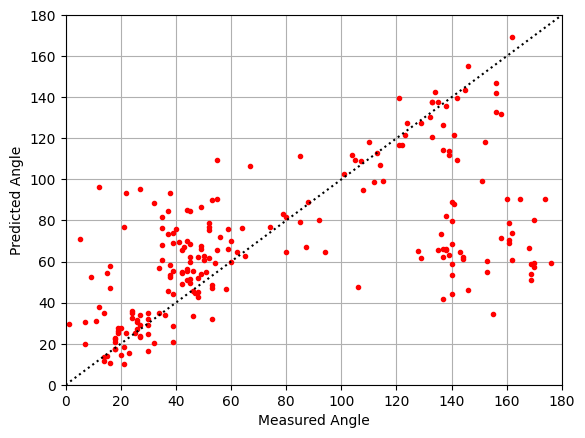

In [170]:
plt.plot(y_test, y_pred, "r.")
plt.plot(np.arange(0, 180), np.arange(0, 180), "k:")
plt.grid()
plt.xlabel("Measured Angle")
plt.ylabel("Predicted Angle")
plt.axis([0, 180, 0, 180])

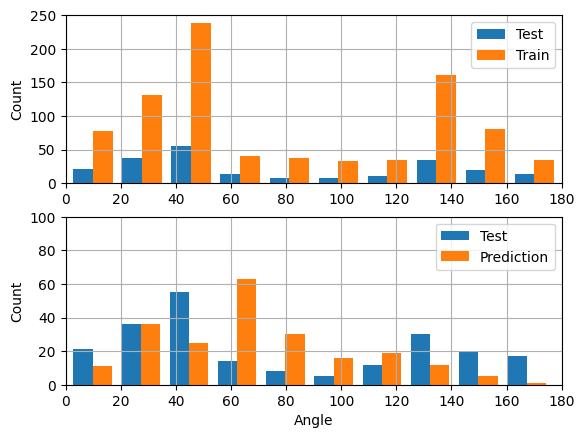

In [171]:
plt.subpl





asdasdasddsalöasdlsadot(211)
plt.hist([y_test, y_train])
plt.grid()
plt.ylabel("Count")
plt.axis([0, 180, 0, 250])
plt.legend(["Test", "Train"])
plt.subplot(212)
plt.hist([y_test, y_pred])
plt.grid()
plt.xlabel("Angle")
plt.ylabel("Count")
plt.axis([0, 180, 0, 100])
plt.legend(["Test", "Prediction"])